In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from pathlib import Path
from tkinter import filedialog
from tkinter import Tk

In [5]:
data_dir = Path('C:/Users/Ntech/Downloads/archive/brain_tumor_dataset')
data_dir

WindowsPath('C:/Users/Ntech/Downloads/archive/brain_tumor_dataset')

In [8]:
yes=list(data_dir.glob('yes/*'))
no=list(data_dir.glob('no/*'))


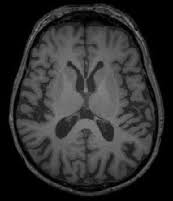

In [10]:
PIL.Image.open(str(no[1]))

In [12]:
image_dictionary={
    'yes tumor':yes,
    'no tumor':no
}

In [14]:
label_dictionary={
    'yes tumor':0,
    'no tumor':1
}

In [16]:
X,y=[], []
for name,images in image_dictionary.items():
   for image in images:
       img=cv2.imread(str(image))
       img_resized=cv2.resize(img,(180,180))
       X.append(img_resized)
       y.append(label_dictionary[name])
    

In [17]:
X=np.array(X)
y=np.array(y)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X,y,random_state=0)

In [21]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomTranslation(0.2, 0.2)
])


In [32]:
print(X_train_scaled.shape)

(189, 180, 180, 3)


In [50]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    data_augmentation,
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

model.compile(optimizer=AdamW(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.fit(X_train_scaled, y_train, 
          epochs=30, 
          validation_data=(X_test_scaled, y_test), 
          callbacks=[early_stopping, reduce_lr], 
          batch_size=8)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5605 - loss: 4.4258 - val_accuracy: 0.5625 - val_loss: 4.0623 - learning_rate: 1.0000e-04
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6405 - loss: 3.9448 - val_accuracy: 0.5781 - val_loss: 3.7154 - learning_rate: 1.0000e-04
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6764 - loss: 3.6371 - val_accuracy: 0.6406 - val_loss: 3.4091 - learning_rate: 1.0000e-04
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7204 - loss: 3.3372 - val_accuracy: 0.5781 - val_loss: 3.2501 - learning_rate: 1.0000e-04
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6510 - loss: 3.1683 - val_accuracy: 0.8125 - val_loss: 2.9230 - learning_rate: 1.0000e-04
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7314 - loss: 2.9436 - val_accuracy: 0.7188 - val_loss: 2.8003 - learning_rate: 1.0000e-04
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7791 - loss:

In [52]:
model.evaluate(X_test_scaled,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.9062 - loss: 1.3470


[1.3647024631500244, 0.890625]

In [54]:
predictions = model.predict(X_test_scaled)
score = tf.nn.softmax(predictions[:20])
y_classes=[np.argmax(element) for element in score]
print(f"Predicted class: {y_classes[:20]} Expected class: {y_test[:20]}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
Predicted class: [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0] Expected class: [1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0]
